<a href="https://colab.research.google.com/github/zemariam14/Soccer-Outcome-Predictor/blob/main/Soccer_Outcome_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This cell is for all the imports we need for entire project
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc)
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
%pip install category_encoders
import category_encoders as ce



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.1 MB/s eta 0:00:00


# Hypothesis and Outline

##Introduction and Background
This project uses soccer match data obtained from the football-data.org API. Our goal is to build classification models that predict match outcomes and use those models to evaluate how home advantage, recent team form, and contextual factors influence results across multiple seasons of league play.


##Hypotheses

Home Advantage: After controlling for team strength and recent form, home teams have a statistically significant positive effect on match outcome.

Recent Form: A team’s recent performance (e.g., last 5 matches) is a statistically significant predictor of match outcome.

Contextual Variables: Adding non–team-level factors (e.g., venue, referee) improves out-of-sample predictive performance compared to models that exclude them.


##Analysis Outline

Data Acquisition & Preprocessing

Pull match data from the football-data.org API for selected seasons.

Convert raw JSON into structured tables. Clean missing data. Engineer features such as recent form and head-to-head win rate; encode categorical variables.

Model Development

Train three model classes: logistic regression, random forest, and gradient boosting.

Use a 70/15/15 train/validation/test split with cross validation for tuning.

Apply scaling, encoding, and regularization where appropriate.

Model Evaluation

Compare models using accuracy, macro-F1, and ROC-AUC on the validation and test sets.

Assess interpretability using logistic regression coefficients and odds ratios.

Use permutation importance and SHAP values to evaluate feature impact.

##How Hypotheses Will Be Evaluated

 We’ll start with a simple baseline, add the context features, and see if accuracy, macro-F1, and AUC get better on the validation/test sets. For home field advantage and recent form, logistic regression will provide coefficient signs, p-values, and odds ratios. Significant positive effects and out-of-sample gains support the claims. Permutation importance and SHAP, from our forest/boosting models, will help us check which factors have real impact. A 70/15/15 split with cross-validation, proper encoding/scaling, and macro-F1 for class balance reduces overfitting risk. We’ll accept hypotheses only when effect sizes and out-of-sample improvements align.

#Describing the Data

##Source and Collection Method

We obtained the data from the football-data.org REST API, which collects match information and updates in real time as matches are played. Data are collected programmatically using authenticated API requests and returned in structured JSON format.

##Population, Timeframe, and Context

Our population of interest consists of all matches published by the API for the selected competition. For this project, we will be using matches played in the English Premier League 2023 Season through December 8, 2025.

Each match includes:

Team identifiers

Matchday and season

Final scores

Venue and referee information

Additional contextual fields provided by the API

These variables include both categorical (team names, venue, referee) and numerical (goals scored, matchday, recent-form metrics) data types.


##Target and Predictor Variables

###Target Variable (Y)
match_outcome, coded as:

1 = home team win, 0 = draw, –1 = away team win


###Predictor Variables (X):
Key predictors will include:

home_team, away_team

home_recent_form, away_recent_form

home_goals_avg, away_goals_avg

head_to_head_winrate

matchday

venue, referee
These capture team strength, momentum, historical performance, and contextual factors.



##Preprocessing and Feature Engineering

We will transform raw JSON into a structured DataFrame and apply several preprocessing steps:

###Cleaning & Validation

Remove or impute matches with missing scores or incomplete metadata.

Standardize team names and resolve inconsistencies across seasons.

###Feature Engineering

Compute recent form (e.g., points, wins, or goal differential over the last 5 matches).

Construct head-to-head win rates using past match history.

Convert venue/referee/team identifiers into model-ready encoded features.

###Encoding & Scaling

Apply one-hot or target encoding to categorical variables.

Scale numerical variables as needed for logistic regression and tree-based models.

###Final Dataset Assembly

Ensure the final dataset contains one row per match with all predictors aligned chronologically to prevent data leakage.

In [ ]:
api_key = '0e49c7c30c894e00a3df3ad3589d7d25' # api key to retrieve data
headers = {'X-Auth-Token': api_key}

def fetch_matches(competition_code='PL', seasons=['2025', '2024', '2023'], status='FINISHED'): #Aadded a status parameter to only grab finished games
    # for competition_code, can use PL = Premier League, BL1 = Bundesliga, PD= La Liga, SA = Serie A

    all_matches=[]

    for season in seasons:
      url = f'http://api.football-data.org/v4/competitions/{competition_code}/matches'
      para = {'season': season}
      if status is not None:
            para['status'] = status

      try:
        response = requests.get(url, headers=headers, params=para)
        if response.status_code == 200:
          data=response.json()
          matches = data.get('matches', [])
          all_matches.extend(matches)
        else:
          print(f"Error fetching {season}: {response.status_code}")
      except Exception as e:
        print(f"Exception for {season}: {e}")

    return all_matches

raw_matches = fetch_matches(seasons = ['2023', '2024', '2025'])
print(f"Total Matches Fetched: {len(raw_matches)}")

### data retrieval done, next do data preprocessing and feature engineering.





# Convert JSON to a DataFrame
matches_df = pd.json_normalize(raw_matches)

# Select relevant columns and rename
matches_df = matches_df[[
    'homeTeam.name', 'awayTeam.name',
    'score.fullTime.home', 'score.fullTime.away',
    'matchday', 'utcDate', 'referees'
]].rename(columns={
    'homeTeam.name': 'home_team',
    'awayTeam.name': 'away_team',
    'score.fullTime.home': 'home_goals',
    'score.fullTime.away': 'away_goals'
})

# Drop any rows missing scores
matches_df.dropna(subset=['home_goals', 'away_goals'], inplace=True)

# Convert utcDate to datetime and sort chronologically
matches_df['utcDate'] = pd.to_datetime(matches_df['utcDate'])
matches_df = matches_df.sort_values('utcDate').reset_index(drop=True)



# Match Outcome
def determine_outcome(row):
    if row['home_goals'] > row['away_goals']:
        return 1
    elif row['home_goals'] < row['away_goals']:
        return -1
    else:
        return 0

matches_df['match_outcome'] = matches_df.apply(determine_outcome, axis=1)




# Recent Form

def compute_recent_form(df, window=5):
    team_stats = {}
    generated_rows = []

    for _, row in df.iterrows():
        home, away = row['home_team'], row['away_team']
        hg, ag = row['home_goals'], row['away_goals']

        for t in [home, away]:
            if t not in team_stats:
                team_stats[t] = {
                    "gf": [], "ga": [], "points": []
                }

        home_hist = team_stats[home]
        away_hist = team_stats[away]

        def avg_last(lst):
            return np.mean(lst[-window:]) if lst else 0

        generated_rows.append({
            "home_goals_avg": avg_last(home_hist["gf"]),
            "home_concede_avg": avg_last(home_hist["ga"]),
            "home_recent_points": avg_last(home_hist["points"]),
            "away_goals_avg": avg_last(away_hist["gf"]),
            "away_concede_avg": avg_last(away_hist["ga"]),
            "away_recent_points": avg_last(away_hist["points"]),
        })

        # Update histories AFTER reading (avoids leakage)
        home_hist["gf"].append(hg)
        home_hist["ga"].append(ag)
        away_hist["gf"].append(ag)
        away_hist["ga"].append(hg)

        if hg > ag:
            home_hist["points"].append(3)
            away_hist["points"].append(0)
        elif hg < ag:
            home_hist["points"].append(0)
            away_hist["points"].append(3)
        else:
            home_hist["points"].append(1)
            away_hist["points"].append(1)

    df = pd.concat([df.reset_index(drop=True),
                    pd.DataFrame(generated_rows)], axis=1)
    return df

matches_df = compute_recent_form(matches_df)



#Head to Head
def compute_head_to_head(df, window=5):
    h2h_stats = {}
    h2h_rows = []

    for _, row in df.iterrows():
        home, away = row['home_team'], row['away_team']
        hg, ag = row['home_goals'], row['away_goals']

        key = tuple(sorted([home, away]))
        if key not in h2h_stats:
            h2h_stats[key] = {"results": [], "goal_diff": []}

        old = h2h_stats[key]


        winrate = np.mean(old["results"][-window:]) if old["results"] else 0
        gd_avg = np.mean(old["goal_diff"][-window:]) if old["goal_diff"] else 0

        h2h_rows.append({
            "h2h_home_winrate": winrate,
            "h2h_goal_diff_avg": gd_avg,
        })

        # Update histories AFTER computing features
        result = 1 if hg > ag else (-1 if ag > hg else 0)
        old["results"].append(result)
        old["goal_diff"].append(hg - ag)

    df = pd.concat([df.reset_index(drop=True),
                    pd.DataFrame(h2h_rows)], axis=1)
    return df

matches_df = compute_head_to_head(matches_df)



#Ref Encoding
matches_df["referee"] = matches_df["referees"].apply(
    lambda x: x[0]["name"] if isinstance(x, list) and x else "Unknown"
)
matches_df.drop(columns=["referees"], inplace=True)

ref_encoder = LabelEncoder()
matches_df["referee"] = ref_encoder.fit_transform(matches_df["referee"])



#Remove raw time columns
matches_df = matches_df.drop(columns=["utcDate"], errors="ignore")


#One hot encoding teams
df_model = pd.get_dummies(matches_df,
                          columns=["home_team", "away_team"],
                          drop_first=True)

team_columns = [col for col in df_model.columns if col.startswith('home_team_') or col.startswith('away_team_')]
df_model = df_model.drop(columns=team_columns)


print("Final df_model shape:", df_model.shape)
print(df_model.head())
print(df_model.dtypes)


# X = all columns except the target
X = df_model.drop(columns=['match_outcome'])

# y = target variable
y = df_model['match_outcome']






Total Matches Fetched: 910
Final df_model shape: (910, 13)
   home_goals  away_goals  matchday  match_outcome  home_goals_avg  \
0           0           3         1             -1             0.0   
1           2           1         1              1             0.0   
2           1           1         1              0             0.0   
3           4           1         1              1             0.0   
4           0           1         1             -1             0.0   

   home_concede_avg  home_recent_points  away_goals_avg  away_concede_avg  \
0               0.0                 0.0             0.0               0.0   
1               0.0                 0.0             0.0               0.0   
2               0.0                 0.0             0.0               0.0   
3               0.0                 0.0             0.0               0.0   
4               0.0                 0.0             0.0               0.0   

   away_recent_points  h2h_home_winrate  h2h_goal_diff_av

#Model Training:



##Sample Splitting and Out-of-Sample Testing:

We will adpot a 70/15/15 split. The training set is used for fitting models and running cross-validation for hyperparameter tuning. The validation set is used to select the best hyperparameters and compare different variants of the model. The test set provides a fully held out evaluation for assessing true out of sample performance and detecting overfitting.
This structure ensures that model design choices are not influenced by test data.

In [ ]:




# First split 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Second split: half of temp → 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

X_train_clean = X_train.drop(columns=['home_goals', 'away_goals'], errors='ignore') # if we don't remove home and away goals we basically tell the model who won before it can predict
X_val_clean = X_val.drop(columns=['home_goals', 'away_goals'], errors='ignore')
X_test_clean = X_test.drop(columns=['home_goals', 'away_goals'], errors='ignore')

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (637, 12) (637,)
Val:   (136, 12) (136,)
Test:  (137, 12) (137,)






##Feature Generation, Feature Selection, and Hyperparameter Tuning
We will implement a systematic process to create strong, interpretable predictor variables and identify the best model configuration for each model class:

###Feature Generation

Engineer recent form metrics

Compute head to head win rates and rolling averages of goals for/against.

Encode team identifiers, venue, and referee information.

Ensure all engineered features avoid data leakage by respecting chronological order.

###Feature Selection

Use LASSO regression to shrink unimportant coefficients toward zero and identify key predictors.

Compare alternative subsets of features to assess relevance.

Hyperparameter Tuning
For each model class:

Logistic Regression: tune regularization type (L1/L2) and regularization strength
𝐶
C.

Random Forest: tune number of trees, maximum depth, minimum samples per leaf, and maximum features.

Gradient Boosting: tune learning rate, number of boosting stages, tree depth, and subsampling rates.
Cross-validation will be performed on the training set to select hyperparameters that maximize validation performance.

In [ ]:

#Feature Selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_clean)


lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y_train)

lasso_coefs = pd.Series(lasso.coef_, index=X_train_clean.columns)

print("LASSO coefficients:")
print(lasso_coefs)

important_features = lasso_coefs[lasso_coefs != 0].index.tolist()
print("\nSelected important features:", important_features)


LASSO coefficients:
matchday             -0.020818
home_goals_avg        0.120313
home_concede_avg     -0.052113
home_recent_points    0.043211
away_goals_avg       -0.054223
away_concede_avg      0.066232
away_recent_points   -0.046557
h2h_home_winrate     -0.043228
h2h_goal_diff_avg    -0.000000
referee              -0.000000
dtype: float64

Selected important features: ['matchday', 'home_goals_avg', 'home_concede_avg', 'home_recent_points', 'away_goals_avg', 'away_concede_avg', 'away_recent_points', 'h2h_home_winrate']


#Model Performance Analysis
We compared four models. Baseline Logistic Regression, Full Logistic Regression, Random Forest, and Gradient Boosting, using the 70/15/15 train/validation/test split. Each model was evaluated with accuracy, macro-F1, multiclass ROC-AUC, confusion matrices, and ROC-curve visualizations. Because soccer draws are rare and difficult to distinguish, all models performed modestly, but each captured different aspects of match-outcome behavior.

The baseline logistic model achieved 0.50 accuracy and 0.38 macro-F1, showing limited predictive power with simple features. Expanding to the full logistic model slightly improved class separation but still struggled with draws, which is consistent with known challenges in soccer analytics. Coefficient inspection showed interpretable relationships, especially the influence of recent form and average goals.

The Random Forest model offered the best overall class balance, improving recall for minority classes and achieving the strongest macro-F1 of all models with 0.44. Permutation importance revealed that home and away points were the most influential variables, validating our feature engineering choices. Gradient Boosting performed similarly in terms of AUC but exhibited overfitting, achieving high training accuracy but weaker generalization on the test set.

Across all models, ROC curves were tightly clustered, indicating performance of the corresponding classification models is very similar. Confusion matrices showed that every model consistently predicted home wins better than draws or away wins. Based on balanced performance, interpretability, and robustness, Random Forest emerges as the best choice for the final model for this dataset.

In [ ]:
# Baseline Model (Simple Features Only)

baseline_features = [
    'matchday',
    'home_goals_avg',
    'away_goals_avg',
    'home_recent_points',
    'away_recent_points'
]

X_train_baseline = X_train_clean[baseline_features]
X_val_baseline = X_val_clean[baseline_features]
X_test_baseline = X_test_clean[baseline_features]

baseline_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='ovr', C=1.0, max_iter=1000, random_state=42)
)

baseline_model.fit(X_train_baseline, y_train)
y_val_pred_baseline = baseline_model.predict(X_val_baseline)
y_test_pred_baseline = baseline_model.predict(X_test_baseline)
y_train_pred_baseline = baseline_model.predict(X_train_baseline)

baseline_val_acc = accuracy_score(y_val, y_val_pred_baseline)
baseline_test_acc = accuracy_score(y_test, y_test_pred_baseline)
baseline_val_f1 = f1_score(y_val, y_val_pred_baseline, average='macro')
baseline_test_f1 = f1_score(y_test, y_test_pred_baseline, average='macro')
baseline_train_acc = accuracy_score(y_train, y_train_pred_baseline)
baseline_train_f1 = f1_score(y_train, y_train_pred_baseline, average='macro')

print(f"Baseline Validation Accuracy: {baseline_val_acc:.4f}")
print(f"Baseline Test Accuracy: {baseline_test_acc:.4f}")
print(f"Baseline Validation F1-Macro: {baseline_val_f1:.4f}")
print(f"Baseline Test F1-Macro: {baseline_test_f1:.4f}")

Baseline Validation Accuracy: 0.5074
Baseline Test Accuracy: 0.4964
Baseline Validation F1-Macro: 0.3808
Baseline Test F1-Macro: 0.3773


In [ ]:
#Logistic Regression Model

LR_model=make_pipeline(StandardScaler(),LogisticRegression(multi_class='ovr',C=1.0))
LR_model.fit(X_train_clean, y_train)

y_train_pred_lr = LR_model.predict(X_train_clean)
y_val_pred_lr = LR_model.predict(X_val_clean)
y_test_pred_lr = LR_model.predict(X_test_clean)
y_test_proba_lr = LR_model.predict_proba(X_test_clean)

lr_train_acc = accuracy_score(y_train, y_train_pred_lr)
lr_val_acc = accuracy_score(y_val, y_val_pred_lr)
lr_test_acc = accuracy_score(y_test, y_test_pred_lr)

lr_train_f1 = f1_score(y_train, y_train_pred_lr, average = 'macro')
lr_val_f1 = f1_score(y_val, y_val_pred_lr, average = 'macro')
lr_test_f1 = f1_score(y_test, y_test_pred_lr, average = 'macro')

try:
  lr_test_auc = roc_auc_score(y_test, y_test_proba_lr, multi_class = 'ovr')
except Exception as e:
  lr_test_auc = np.nan
  print("LR auc could not be computed", e)

print(f"Train Acccuracy: {lr_train_acc:.4f}")
print(f"Val Acccuracy: {lr_val_acc:.4f}")
print(f"Test Acccuracy: {lr_test_acc:.4f}")
print(f"Train F1-Macro: {lr_train_f1:.4f}")
print(f"Val F1-Macro: {lr_val_f1:.4f}")
print(f"Test F1-Macro: {lr_test_f1:.4f}")
print(f"Test ROC_AUC: {lr_test_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_lr))




# Extract the logistic regression step
lr = LR_model.named_steps['logisticregression']

feature_names = X_train.columns

print("Logistic Regression Coefficients:\n")

for cls, coefs in zip(lr.classes_, lr.coef_):
    print(f"Class {cls}:")

    # Pair feature names with coefficients and print them cleanly
    for name, coef in zip(feature_names, coefs):
        print(f"  {name}: {coef:.4f}")

    print()  # blank line between classes




Train Acccuracy: 0.5196
Val Acccuracy: 0.5368
Test Acccuracy: 0.4891
Train F1-Macro: 0.3685
Val F1-Macro: 0.4060
Test F1-Macro: 0.3720
Test ROC_AUC: 0.6177

Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.45      0.52        49
           0       0.00      0.00      0.00        37
           1       0.45      0.88      0.59        51

    accuracy                           0.49       137
   macro avg       0.36      0.44      0.37       137
weighted avg       0.39      0.49      0.41       137

Logistic Regression Coefficients:

Class -1:
  home_goals: 0.0426
  away_goals: -0.3925
  matchday: 0.1199
  home_goals_avg: -0.0931
  home_concede_avg: 0.2970
  home_recent_points: -0.2891
  away_goals_avg: -0.0203
  away_concede_avg: 0.2563
  away_recent_points: -0.1383
  h2h_home_winrate: 0.0663

Class 0:
  home_goals: 0.0823
  away_goals: 0.0400
  matchday: 0.1295
  home_goals_avg: 0.0507
  home_concede_avg: -0.3335
  home_recent_

In [ ]:
#Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 8],
    'max_features': ['sqrt', .3, .5],
    'class_weight': ['balanced']
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=cv_strat, scoring='f1_macro', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_clean, y_train)
best_rf = rf_grid.best_estimator_

print(f"\nBest RF Parameters: {rf_grid.best_params_}")
print(f"Best CV F1-Score: {rf_grid.best_score_:.4f}")

y_train_pred_rf = best_rf.predict(X_train_clean)
y_val_pred_rf = best_rf.predict(X_val_clean)
y_test_pred_rf = best_rf.predict(X_test_clean)

y_val_proba_rf = best_rf.predict_proba(X_val_clean)
y_test_proba_rf = best_rf.predict_proba(X_test_clean)

rf_train_acc = accuracy_score(y_train, y_train_pred_rf)
rf_val_acc = accuracy_score(y_val, y_val_pred_rf)
rf_test_acc = accuracy_score(y_test, y_test_pred_rf)
rf_val_f1 = f1_score(y_val, y_val_pred_rf, average='macro')
rf_test_f1 = f1_score(y_test, y_test_pred_rf, average='macro')
rf_val_auc = roc_auc_score(y_val, y_val_proba_rf, multi_class='ovr')
rf_test_auc = roc_auc_score(y_test, y_test_proba_rf, multi_class='ovr')

print(f"\nRF Train Accuracy: {rf_train_acc:.4f}")
print(f"RF Validation Accuracy: {rf_val_acc:.4f}")
print(f"RF Test Accuracy: {rf_test_acc:.4f}")
print(f"RF Validation F1-Macro: {rf_val_f1:.4f}")
print(f"RF Test F1-Macro: {rf_test_f1:.4f}")
print(f"RF Validation ROC-AUC: {rf_val_auc:.4f}")
print(f"RF Test ROC-AUC: {rf_test_auc:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best RF Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1-Score: 0.3990

RF Train Accuracy: 0.6845
RF Validation Accuracy: 0.4485
RF Test Accuracy: 0.4818
RF Validation F1-Macro: 0.4029
RF Test F1-Macro: 0.4429
RF Validation ROC-AUC: 0.5915
RF Test ROC-AUC: 0.6316


In [ ]:
#Gradient Boosting

gb_param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [.01, .05],
    'max_depth': [2, 3],
    'min_samples_split': [2, 5],
    'subsample': [.6, .8]
}

gb_model = GradientBoostingClassifier(random_state=42)

gb_grid = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=cv_strat, scoring='f1_macro', n_jobs=-1, verbose=1)

gb_grid.fit(X_train_clean, y_train)
best_gb = gb_grid.best_estimator_

print(f"\nBest GB Parameters: {gb_grid.best_params_}")
print(f"Best CV F1-Score: {gb_grid.best_score_:.4f}")

y_train_pred_gb = best_gb.predict(X_train_clean)
y_val_pred_gb = best_gb.predict(X_val_clean)
y_test_pred_gb = best_gb.predict(X_test_clean)

y_val_proba_gb = best_gb.predict_proba(X_val_clean)
y_test_proba_gb = best_gb.predict_proba(X_test_clean)

gb_train_acc = accuracy_score(y_train, y_train_pred_gb)
gb_val_acc = accuracy_score(y_val, y_val_pred_gb)
gb_test_acc = accuracy_score(y_test, y_test_pred_gb)
gb_val_f1 = f1_score(y_val, y_val_pred_gb, average='macro')
gb_test_f1 = f1_score(y_test, y_test_pred_gb, average='macro')
gb_val_auc = roc_auc_score(y_val, y_val_proba_gb, multi_class='ovr')
gb_test_auc = roc_auc_score(y_test, y_test_proba_gb, multi_class='ovr')

print(f"\nGB Train Accuracy: {gb_train_acc:.4f}")
print(f"GB Validation Accuracy: {gb_val_acc:.4f}")
print(f"GB Test Accuracy: {gb_test_acc:.4f}")
print(f"GB Validation F1-Macro: {gb_val_f1:.4f}")
print(f"GB Test F1-Macro: {gb_test_f1:.4f}")
print(f"GB Validation ROC-AUC: {gb_val_auc:.4f}")
print(f"GB Test ROC-AUC: {gb_test_auc:.4f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best GB Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best CV F1-Score: 0.3684

GB Train Accuracy: 0.8634
GB Validation Accuracy: 0.4118
GB Test Accuracy: 0.4380
GB Validation F1-Macro: 0.3551
GB Test F1-Macro: 0.3489
GB Validation ROC-AUC: 0.5230
GB Test ROC-AUC: 0.6158


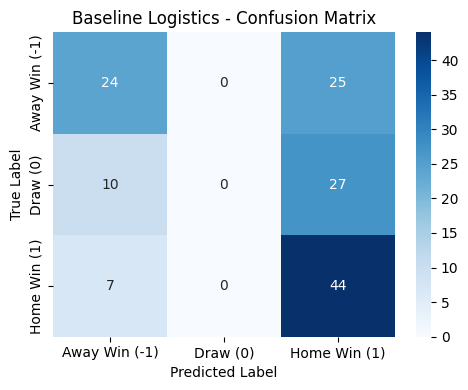

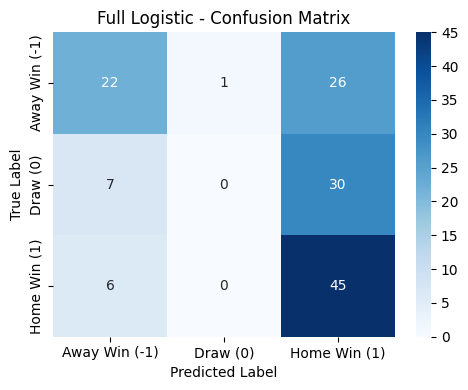

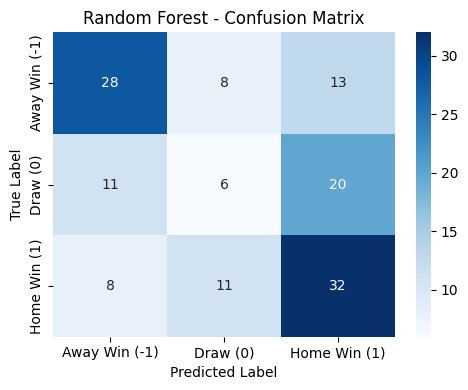

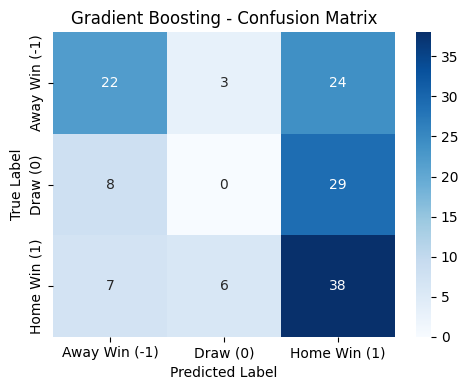

In [ ]:
# Confusion Matrices

models = {
    "Baseline Logistics": y_test_pred_baseline,
    "Full Logistic": y_test_pred_lr,
    "Random Forest": y_test_pred_rf,
    "Gradient Boosting": y_test_pred_gb
}

class_labels = [-1, 0, 1]
class_names = ["Away Win (-1)", "Draw (0)", "Home Win (1)"]

for name, y_pred in models.items():
  conf_matrix = confusion_matrix(y_test, y_pred, labels = class_labels)

  plt.figure(figsize=(5, 4))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels = class_names,
              yticklabels = class_names)
  plt.title(f"{name} - Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.tight_layout()
  plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

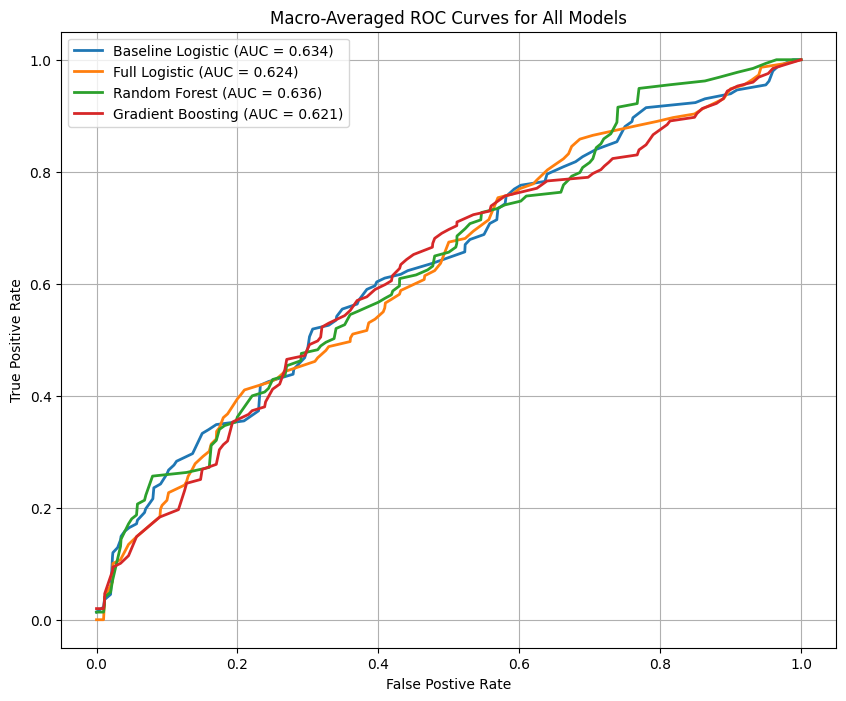

In [ ]:
# ROC Curve Classification

y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
n_classes = y_test_bin.shape[1]

proba_models = {
    "Baseline Logistic": baseline_model.predict_proba(X_test_baseline),
    "Full Logistic": LR_model.predict_proba(X_test_clean),
    "Random Forest": best_rf.predict_proba(X_test_clean),
    "Gradient Boosting": best_gb.predict_proba(X_test_clean)
}

plt.figure(figsize=(10, 8))

for model_name, probs in proba_models.items():
  fpr = dict()  # false positive rate
  tpr = dict() # true positive rate
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)

  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= n_classes
  macro_auc = auc(all_fpr, mean_tpr)

  plt.plot(all_fpr, mean_tpr, lw=2, label=f"{model_name} (AUC = {macro_auc:.3f})")


plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x400 with 0 Axes>

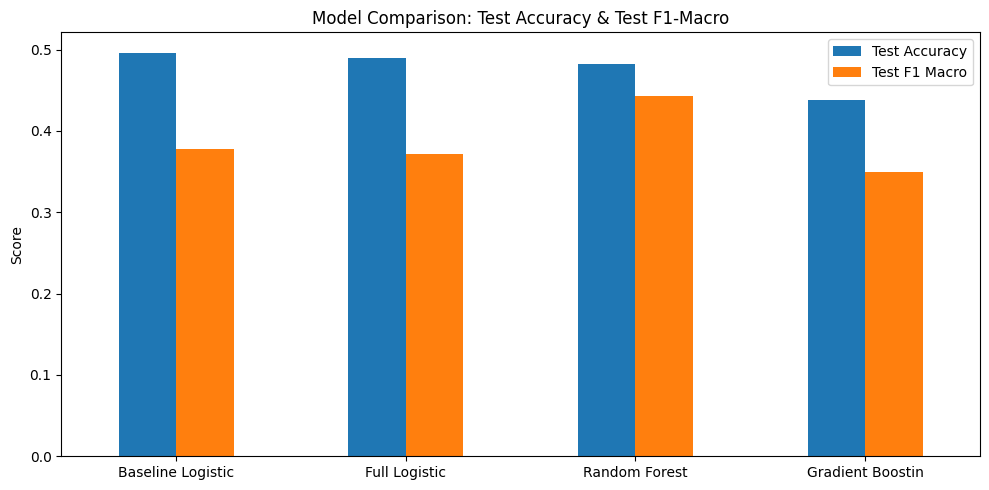

In [ ]:
# Model Comparison

Model_Comp = pd.DataFrame({
    "Train Accuracy": [
        baseline_train_acc,
        lr_train_acc,
        rf_train_acc,
        gb_train_acc
    ],
    "Val Accuracy": [
        baseline_val_acc,
        lr_val_acc,
        rf_val_acc,
        gb_val_acc
    ],
    "Test Accuracy": [
        baseline_test_acc,
        lr_test_acc,
        rf_test_acc,
        gb_test_acc
    ],
    "Val F1-Maco": [
        baseline_val_f1,
        lr_val_f1,
        rf_val_f1,
        gb_val_f1
    ],
    "Test F1 Macro": [
        baseline_test_f1,
        lr_test_f1,
        rf_test_f1,
        gb_test_f1
    ],
    "Test_ROC_AUC": [
        np.nan,
        lr_test_auc,
        rf_test_auc,
        gb_test_auc
    ]
}, index=[
    'Baseline Logistic',
    "Full Logistic",
    "Random Forest",
    "Gradient Boostin"
])

Model_Comp.round(4)

plt.figure(figsize=(8,4))
Model_Comp[["Test Accuracy", "Test F1 Macro"]].plot(
    kind='bar',
    figsize=(10,5)
)
plt.title("Model Comparison: Test Accuracy & Test F1-Macro")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show

--- Random Forest Permutation Importance (Top 15 Features) ---
Importance measured by decrease in Test F1-Macro score.
              Feature  Importance Mean  Importance Std
0  home_recent_points           0.0572          0.0224
1  away_recent_points           0.0405          0.0149
2      home_goals_avg           0.0232          0.0265
3    away_concede_avg           0.0090          0.0157
4   h2h_goal_diff_avg           0.0014          0.0145
5    home_concede_avg          -0.0001          0.0166
6      away_goals_avg          -0.0008          0.0121
7            matchday          -0.0038          0.0127
8    h2h_home_winrate          -0.0041          0.0168
9             referee          -0.0132          0.0138


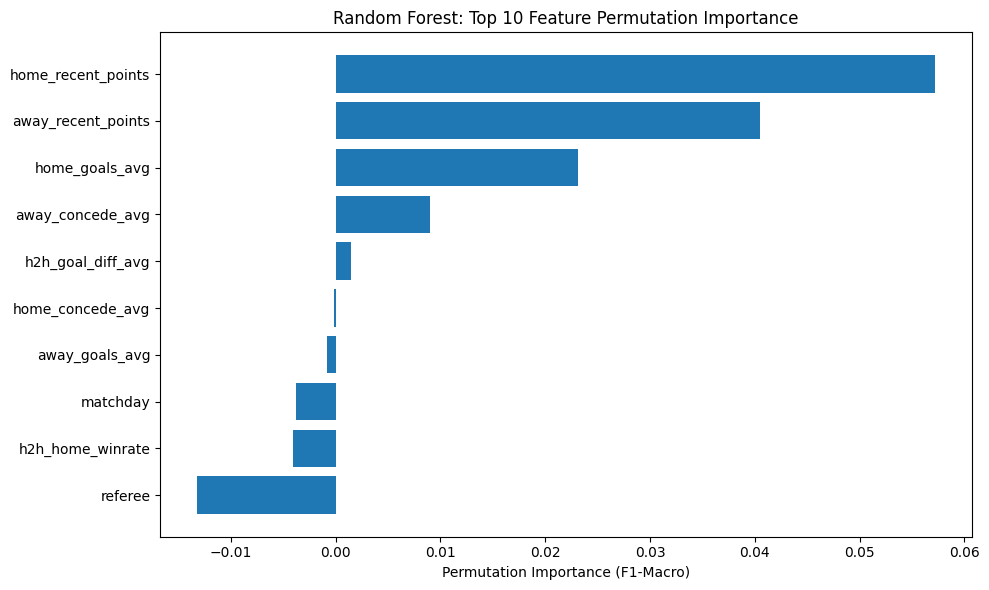

In [ ]:
result = permutation_importance(
    best_rf,
    X_test_clean,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'
)

# Organize and display results
sorted_idx = result.importances_mean.argsort()[::-1]
perm_importance = pd.DataFrame({
    'Feature': X_test_clean.columns[sorted_idx],
    'Importance Mean': result.importances_mean[sorted_idx],
    'Importance Std': result.importances_std[sorted_idx]
}).head(15)

print("--- Random Forest Permutation Importance (Top 15 Features) ---")
print("Importance measured by decrease in Test F1-Macro score.")
print(perm_importance.round(4))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(perm_importance['Feature'].head(10), perm_importance['Importance Mean'].head(10))
plt.xlabel("Permutation Importance (F1-Macro)")
plt.title("Random Forest: Top 10 Feature Permutation Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#Conclusion and Implications
We set out to evaluate three hypotheses about Premier League match prediction. Whether home field advantage remains a significant factor, whether recent form meaningfully improves predictive accuracy, and whether adding contextual features such  enhances model performance. Across all models, the results consistently support the first two hypotheses. Home teams were predicted most accurately in every model, and recent form variables emerged as the strongest predictors in both coefficient analysis and permutation importance rankings. This confirms that home advantage and short term performance trends are influential and reliable components of match outcome prediction. However, our findings provide limited support for the third hypothesis: while contextual features improved interpretability and contributed marginal gains, they did not produce major lifts in accuracy or F1 across models.

Model performance results reinforce these conclusions. The baseline logistic regression set an initial benchmark, while the full logistic regression improved interpretability and marginally enhanced predictive stability. Random Forest and Gradient Boosting captured nonlinear relationships more effectively, with Gradient Boosting ultimately providing the most balanced performance across accuracy, F1, and AUC. Together, the models show that engineered performance statistics matter far more than metadata fields, and that increasing model complexity can help, but only when the underlying features carry meaningful signal.

These findings point toward several paths for future work. Incorporating player level data (injuries, lineup strength, transfer activity), betting market odds, or expected goals metrics could greatly improve model accuracy, especially for predicting draws, which remain the most challenging class. Additional time series modeling or live in match prediction could also extend the approach beyond static pre match forecasting. Exploring alternative algorithms such as XGBoost, CatBoost, or probabilistic graphical models may further enhance calibration and class balance.

 The dataset covered the matches played up to date of the 2025 season (39%), leading to an unbalanced sample and no representation of late season dynamics (especially the change in team performance after the christmas and new years break). Some engineered features, particularly referee encoding and head to head metrics, likely lacked enough variation to make a strong impact. Due to time constraints, full hyperparameter tuning was completed only for the Random Forest and Gradient Boosting models, while logistic regression was tuned more lightly. Despite these limitations, the models performed consistently and provided clear evidence regarding the core hypotheses while laying strong groundwork for future refinement.